In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('merged_data.csv')
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [3]:
df.shape

(15000, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [5]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


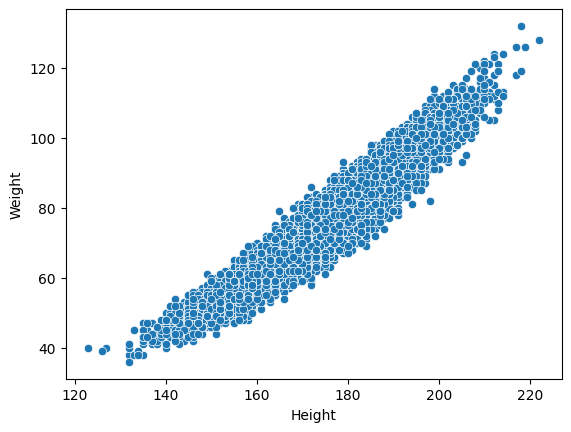

In [6]:
sb.scatterplot(x='Height', y='Weight', data=df)
plt.show()

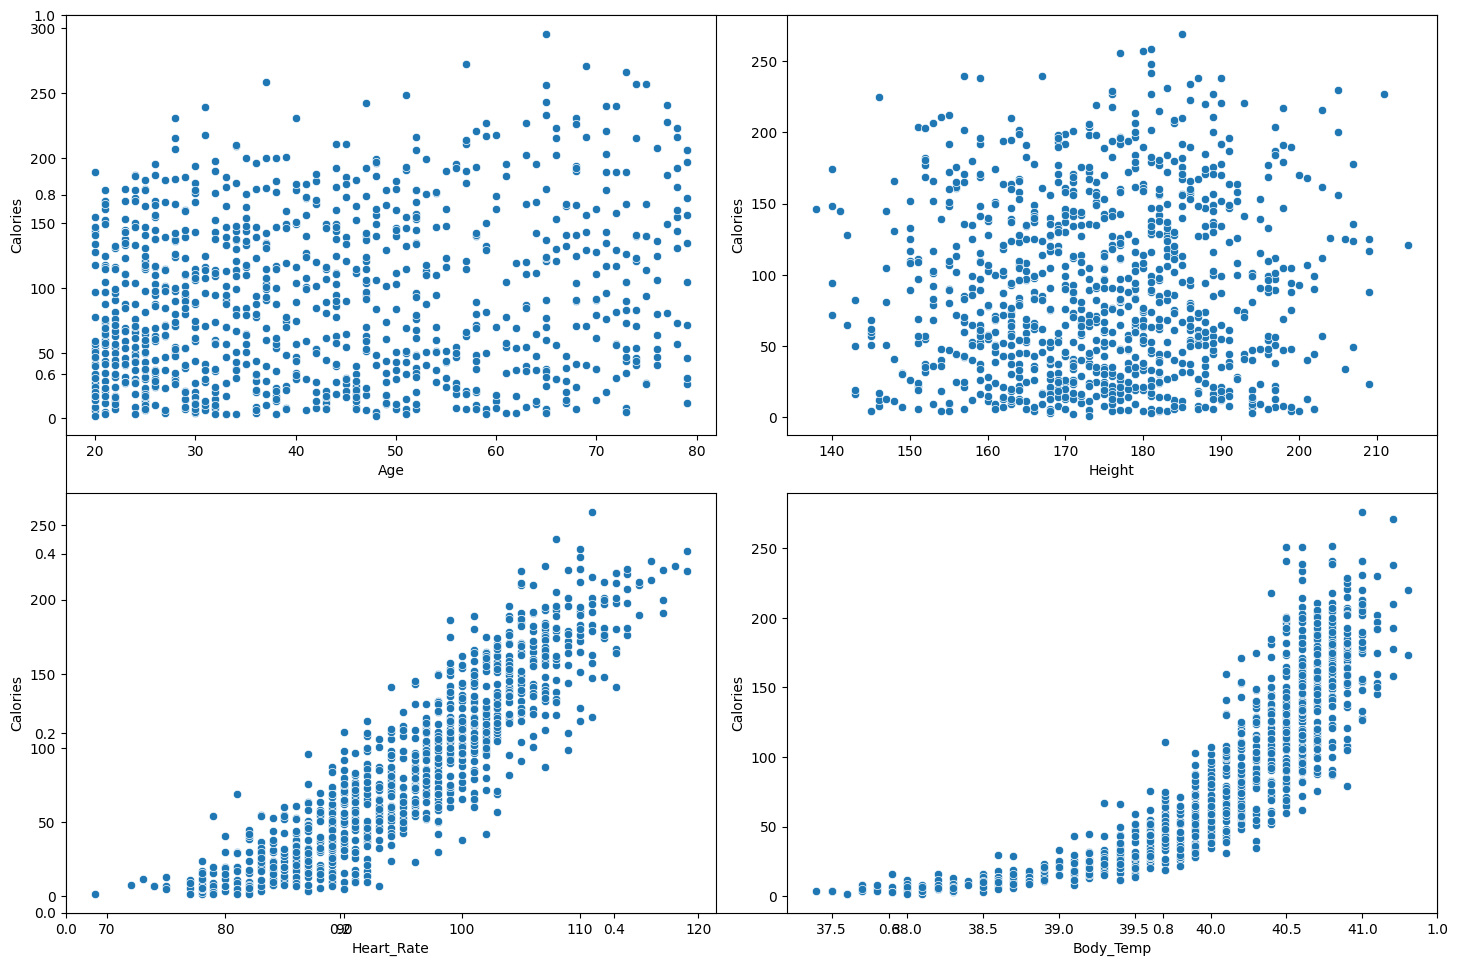

In [7]:
features = ['Age', 'Height', 'Heart_Rate', 'Body_Temp']

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    x = df.sample(1000)
    sb.scatterplot(x=col, y='Calories', data=x)
plt.tight_layout()
plt.show()

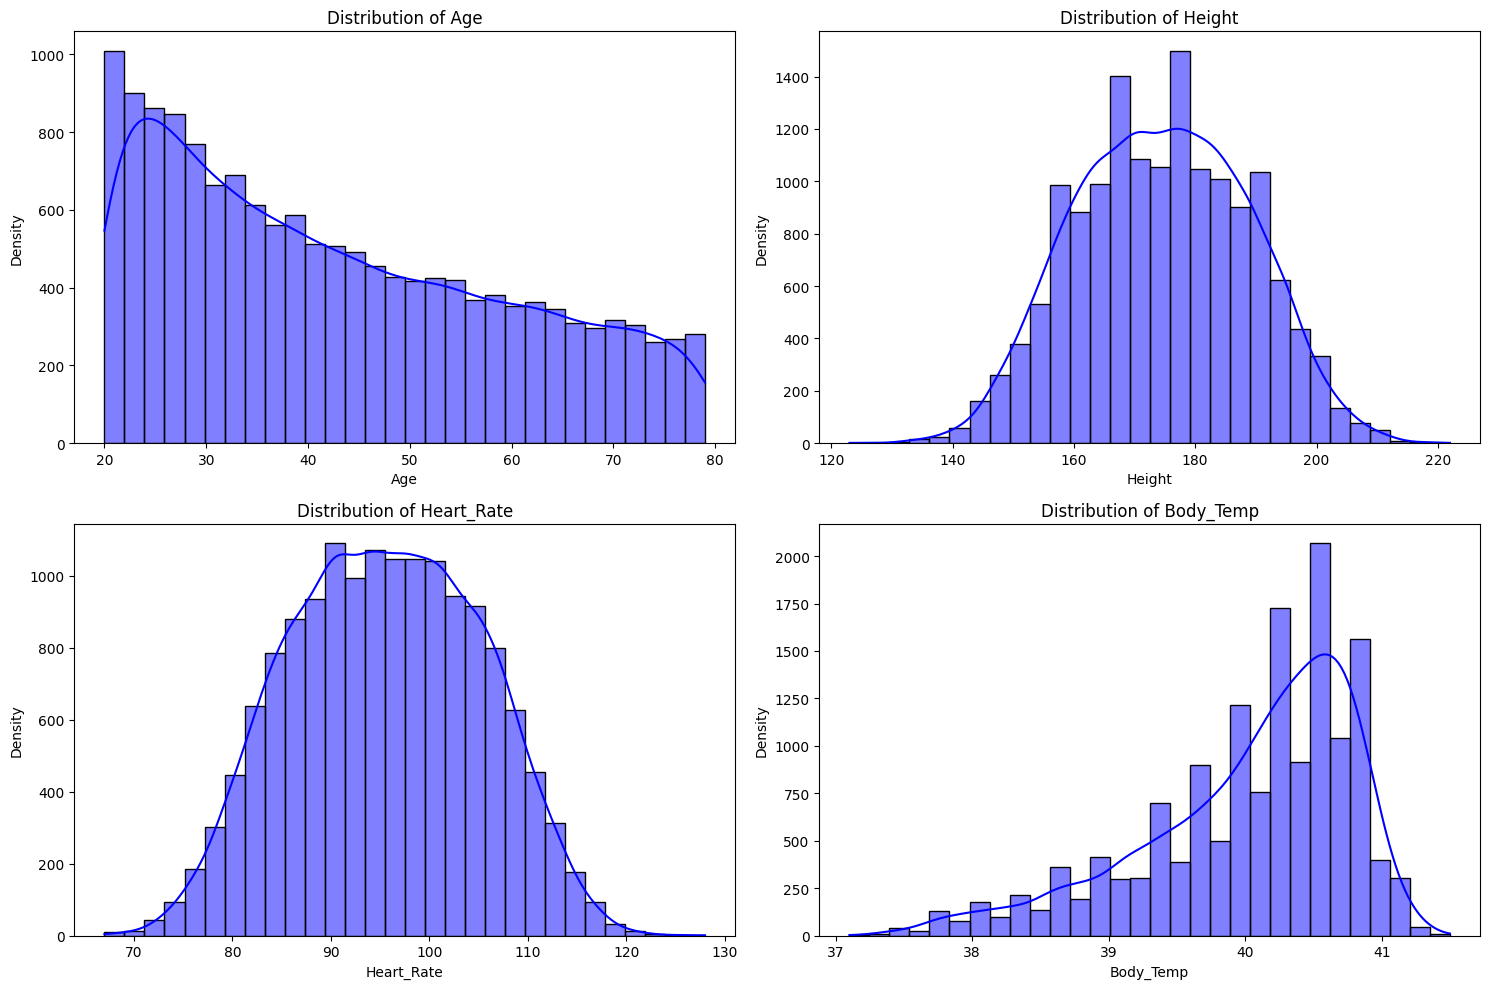

In [8]:

# Create subplots for normal distribution visualization
plt.figure(figsize=(15, 10))

for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    
    # Plot histogram with KDE (smooth curve to approximate normal distribution)
    sb.histplot(df[col], kde=True, bins=30, color='blue')
    
    # Titles and labels
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


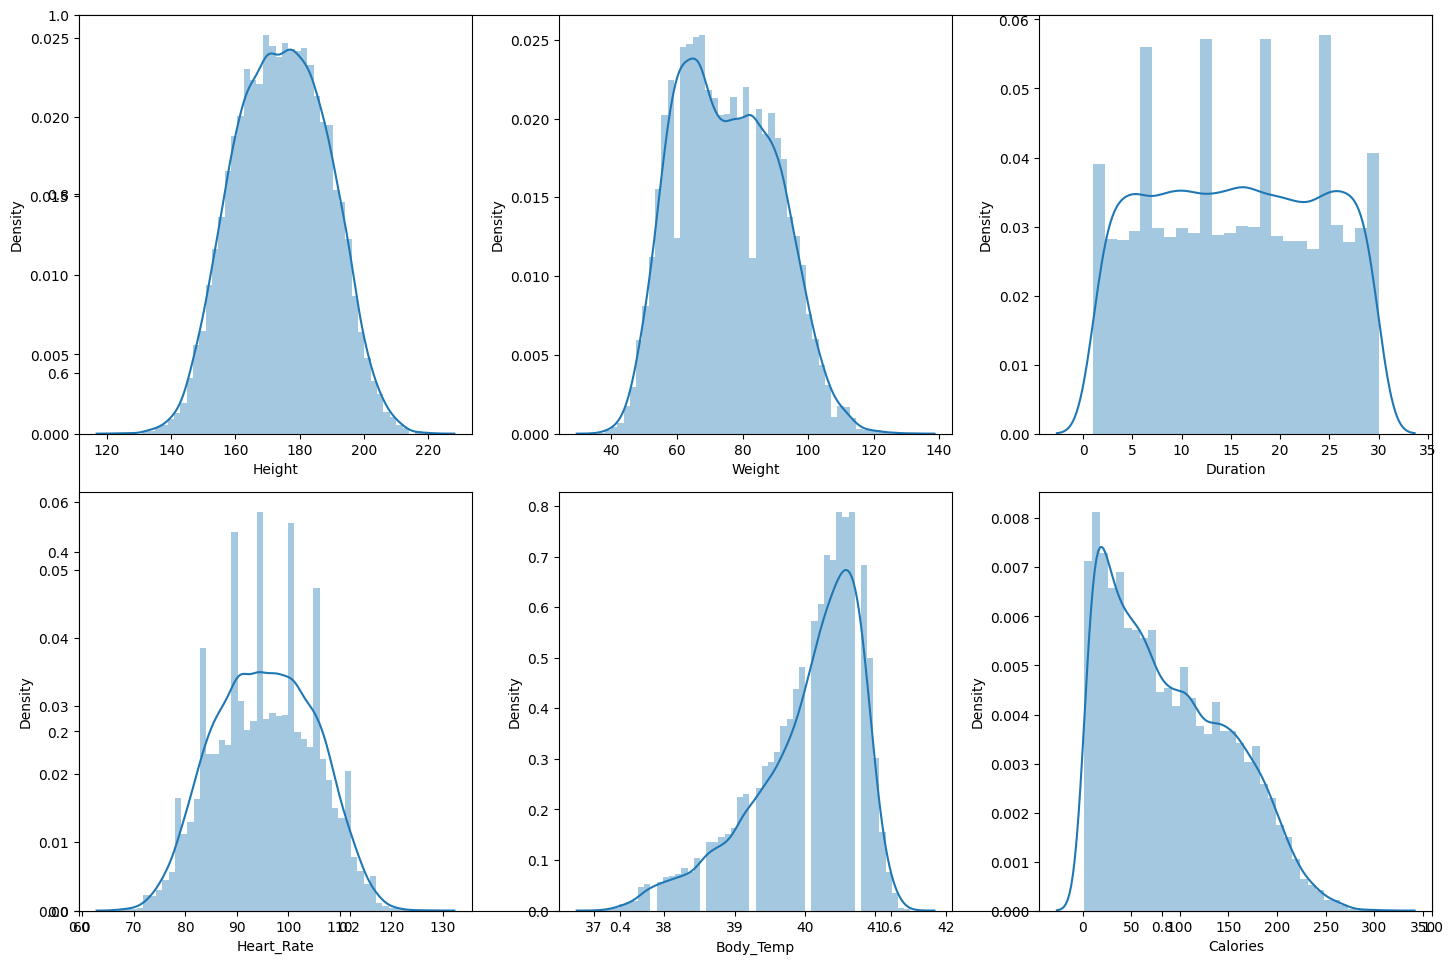

In [8]:
features = df.select_dtypes(include='float').columns

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

In [9]:
df.replace({'male': 0, 'female': 1},
           inplace=True)
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0


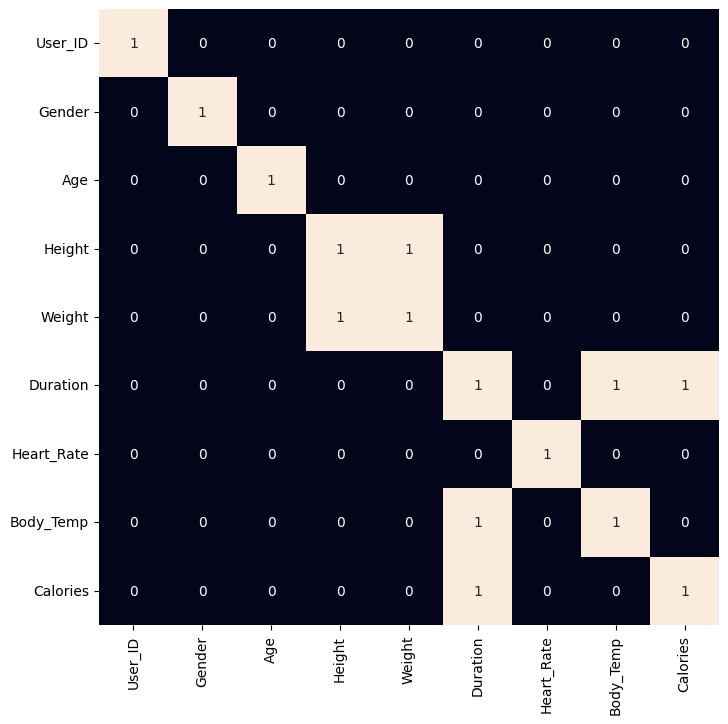

In [10]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.corr() > 0.9,
           annot=True,
           cbar=False)
plt.show()

Here we have a serious problem of data leakage as there is a feature that is highly correlated with the target column which is calories.

In [11]:
to_remove = ['Weight', 'Duration']
df.drop(to_remove, axis=1, inplace=True)

In [12]:
features = df.drop(['User_ID', 'Calories'], axis=1)
target = df['Calories'].values

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.1,
                                      random_state=22)
X_train.shape, X_val.shape

((13500, 5), (1500, 5))

In [13]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [14]:
from sklearn.metrics import mean_absolute_error as mae
models = [LinearRegression(), XGBRegressor(),
          Lasso(), RandomForestRegressor(), Ridge()]

for i in range(5):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  17.893463692619434
Validation Error :  18.007896272831253

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  7.89463304294701
Validation Error :  10.12050432946533

Lasso() : 
Training Error :  17.915089584958036
Validation Error :  17.995033

Creates and saves our model to a pkl file to be used for later.

In [15]:
import joblib
save_model = XGBRegressor()
save_model.fit(X_train,Y_train)
joblib.dump(save_model, 'calories_predictor.pkl')

['calories_predictor.pkl']

Saves scaler to helps the XGBoost Regressor (XGBRegressor) by ensuring that all input features are on a similar scale.
Normalizes the input.


In [16]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Looking at what is being used as features/inputs for the models, weight and duration arent there bc we removed them earlier.

In [17]:
print(features.columns)  # Print feature names used in training
print(X_train.shape)  # Check number of columns in training data


Index(['Gender', 'Age', 'Height', 'Heart_Rate', 'Body_Temp'], dtype='object')
(13500, 5)


Down below is the reason why weight and duration were removed.

Great question! The reason **Weight** and **Duration** were removed is because they were **highly correlated** with the target variable (`Calories`). This situation is referred to as **data leakage**. Let me break it down for you.

---

### **What is Data Leakage?**
Data leakage happens when a feature in your dataset **unfairly gives away** information about the target variable (`Calories`). This makes the model perform **too well** during training but fail on new, unseen data.

### **Why Were `Weight` and `Duration` Removed?**
1. **`Duration` is Directly Related to Calories Burned**  
   - The longer you exercise, the more calories you burn.  
   - If `Duration` is included, the model **doesn’t learn** any meaningful patterns—it's just memorizing the fact that **more time = more calories**.  
   - This is like giving the model the answer to the test!

2. **`Weight` Strongly Affects Calories Burned**  
   - Heavier people burn more calories doing the same activity.  
   - If `Weight` is highly correlated with `Calories`, then the model **might overfit**, meaning it just relies on weight rather than learning useful patterns from other features.

### **How Do We Detect This?**
You can check for **high correlation** between features and the target variable (`Calories`) using a heatmap:
```python
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sb.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
```
- If `Weight` or `Duration` have a **correlation close to 1** with `Calories`, it means they are **too directly related**.
- Typically, **features with correlation > 0.9** are at risk of causing data leakage.

### **What Happens If We Keep These Features?**
- The model will perform **extremely well** during training but fail to generalize to new data.
- This is because the model isn’t learning useful patterns—it’s just relying on a shortcut (like looking at duration directly).

---

### **What Features Are Used Instead?**
To avoid data leakage, we use features like:
✅ `Gender`  
✅ `Age`  
✅ `Height`  
✅ `Heart_Rate`  
✅ `Body_Temp`  

These features **indirectly influence calorie burn** without leaking direct information like `Duration`.

---

### **Summary**
- **Data leakage** occurs when a feature is too closely related to the target variable.  
- `Duration` and `Weight` were removed because they **directly determine calories burned**, making the model rely on them instead of learning general patterns.  
- Instead, we use features like **Heart Rate and Body Temperature**, which are related to calorie burn **but don’t directly determine it**.  
- **Check correlation** to detect possible leakage—if a feature is highly correlated (>0.9), it might be problematic.

Let me know if you need more clarification! 🚀